- Utilize Linear and Non-Linear (polynomial with degree n) regression models to compare trends for a single state (each member should choose different state) and its counties (top 5 with highest number of cases). Start your data from 2020.06.01 (Monday) to 2021.01.03 (Sunday). 
    - X-Axis - number of days, Y-Axis number of new cases and deaths. Calcluate error using RMSE.(10 points)
    - Identify which counties are most at risk. Model for top 5 counties with cases within a state and describe their trends. (10 points)
    - Perform hypothesis tests on questions identified in Stage III. (30 points)
        - e.x. *Does higher employment data (overall employment numbers) lead to higher covid case numbers or more rapid increase in covid cases.*. Here you would compare the covid cases to the state or county level enrichment data to prove or disprove your null hypothesis. In this case there will be a two tail - two sample t-test to see if there is a difference and then one-tail - two sample t-test to show higher or lower.
        - you can also make 3 new hypotheses and do hypothesis tests on them.
        - Depending on your type of data you can also perform Chi-square test for categorical hypothesis testing. 
- For each of the aforemention analysis plot figures, the figures should include (10 points)
    - trend line (based on the datasets from 2020.06.01 (Monday) to 2021.01.03 (Sunday)).
    - prediction path (forecast 1 week).
    - confidence intervals (error in prediction). (Further materials you may need to explore: https://lmc2179.github.io/posts/confidence_prediction.html; https://www.geeksforgeeks.org/how-to-plot-a-confidence-interval-in-python/)

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# read in csv files
cases = pd.read_csv("../covid_confirmed_usafacts.csv")
deaths = pd.read_csv("../covid_deaths_usafacts.csv")
population = pd.read_csv("../Full_Covid_Data.csv")

In [3]:
# Functions for state stuffs
def parse_datetime_state(full_data, state):
    #get date range for chosen state
    state_data = full_data[full_data['State'] == state]
    dates = state_data.loc[:, [i not in ["countyFIPS","County Name", "State", "StateFIPS"] for i in state_data]] #Extract non dates
    dates.columns = pd.to_datetime(dates.columns) #Fix columns to be date times
    dates = dates.loc[:, [(i >= datetime.datetime(2020, 5, 25)) and (i <= datetime.datetime(2021, 1, 10)) for i in dates]] #Extract correct time
    return dates #make dates start 1 week earlier for get_weekly() purposes

def parse_datetime_county(full_data, county):
    #get date range for chosen state
    county_data = full_data[full_data['County Name'] == county]
    dates = county_data.loc[:, [i not in ["countyFIPS","County Name", "State", "StateFIPS"] for i in county_data]] #Extract non dates
    dates.columns = pd.to_datetime(dates.columns) #Fix columns to be date times
    dates = dates.loc[:, [(i >= datetime.datetime(2020, 5, 25)) and (i <= datetime.datetime(2021, 1, 10)) for i in dates]] #Extract correct time
    return dates #make dates start 1 week earlier for get_weekly() purposes

def get_weekly(dates): #tweaked function from stage 2

    weeks = [range(i, i + 7) for i in range(0, len(dates.columns), 7)]
    dates.iloc[:, weeks[0]]
    
    stats = pd.DataFrame({"week": [],"sum" : []})
    
    for i in range(len(weeks)-1):
        date = dates.iloc[:, weeks[i+1]].iloc[0, :].keys()[0]
        #Subtract numbers from previous week to get new case/death data (current data is cumulative)
        week = (dates.iloc[:, weeks[i+1]].sum(axis = 1)) - (dates.iloc[:, weeks[i]].sum(axis = 1))
        wsum = week.sum()/7/7
        new_row = pd.DataFrame({"week": date,"sum" : (wsum)}, index=[i])
        stats = pd.concat([stats, new_row])
    return stats

### Set up & plot state data (cases & deaths)

In [4]:
state = 'SC'
norm_factor = 10000

pop_SC = population.loc[population["State"] == state]
pop_SC_sum = pop_SC['population'].sum()

cases_dates_SC = parse_datetime_state(cases, state)
deaths_dates_SC = parse_datetime_state(deaths, state)
cases_weeks_SC = get_weekly(cases_dates_SC)
deaths_weeks_SC = get_weekly(deaths_dates_SC)

Text(0.5, 1.0, 'SC Cases')

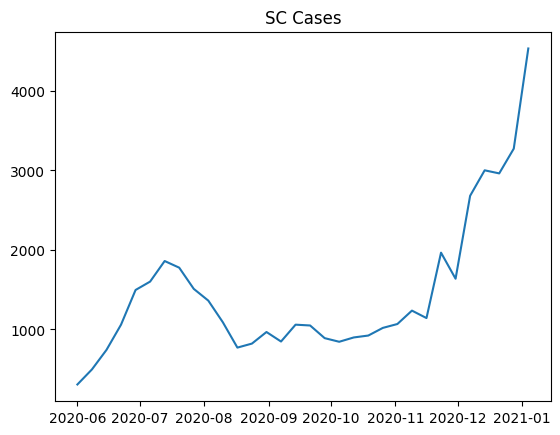

In [5]:
plt.plot(cases_weeks_SC["week"], cases_weeks_SC["sum"])
plt.title("SC Cases")

Text(0.5, 1.0, 'SC Deaths')

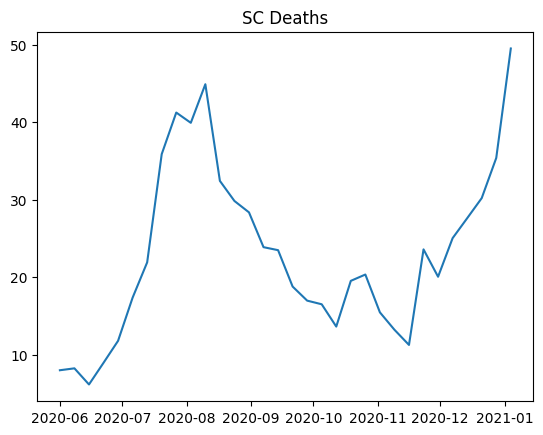

In [6]:
plt.plot(deaths_weeks_SC["week"], deaths_weeks_SC["sum"])
plt.title("SC Deaths")

### Set up & plot counties (Cases & Deaths)

In [7]:
county_names = ["Charleston County ", "Greenville County ", "Horry County ", "Richland County ", "Spartanburg County "]
cases_counties = cases[(cases['State'] == state)&(cases['County Name'].isin(county_names))]
deaths_counties = deaths[(deaths['State'] == state)&(deaths['County Name'].isin(county_names))]
county_pop = pop_SC.loc[cases['County Name'].isin(county_names),(pop_SC.columns.isin(["population"]))]
county_cweeks = []
county_dweeks = []
norm_factor = 1000
for i in range (5) :
    county_dates = parse_datetime_county(cases_counties, county_names[i])
    county_cweeks.append(get_weekly(county_dates))
    county_dates = parse_datetime_county(deaths_counties, county_names[i])
    county_dweeks.append(get_weekly(county_dates))

#Charleston County, Greenville County, Horry County, Richland County, Spartanburg County

Text(0.5, 1.0, 'Counties Cases')

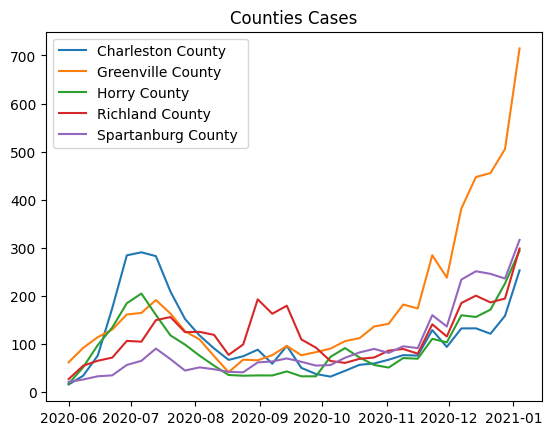

In [8]:
for i in range (5) :
    plt.plot(county_cweeks[i]["week"], county_cweeks[i]["sum"])
plt.legend(county_names)
plt.title("Counties Cases")

Text(0.5, 1.0, 'Counties Deaths')

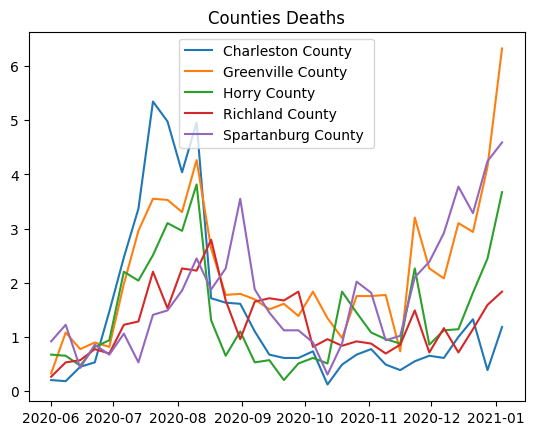

In [9]:
for i in range (5) :
    plt.plot(county_dweeks[i]["week"], county_dweeks[i]["sum"])
plt.legend(county_names)
plt.title("Counties Deaths")

## Regression

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sklearn.metrics import mean_squared_error
from sktime.utils.plotting import plot_series

In [18]:
cX = []
cy = []
dX = []
dy = []
for i in range(5) :
    cX.append(county_cweeks[i]["week"])
    cy.append(county_cweeks[i]["sum"])
    dX.append(county_dweeks[i]["week"])
    dy.append(county_dweeks[i]["sum"])

### Linear Regression

In [23]:
cy_train = []
cy_test = []
dy_train = []
dy_test = []

for i in range(5) :
    y_train, y_test = temporal_train_test_split(cy[i], test_size=1)
    cy_train.append(y_train)
    cy_test.append(y_test)
    y_train, y_test = temporal_train_test_split(dy[i], test_size=1)
    dy_train.append(y_train)
    dy_test.append(y_test)

In [28]:
cfh = []
dfh = []
for i in range(5) :
    cfh.append(ForecastingHorizon(cy_test[i].index, is_relative=False))
    dfh.append(ForecastingHorizon(dy_test[i].index, is_relative=False))
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=1, strategy="recursive")

In [29]:
cy_pred = []
dy_pred = []
for i in range(5) :
    forecaster.fit(cy_train[i])
    cy_pred.append(forecaster.predict(cfh[i]))
    forecaster.fit(dy_train[i])
    dy_pred.append(forecaster.predict(dfh[i]))

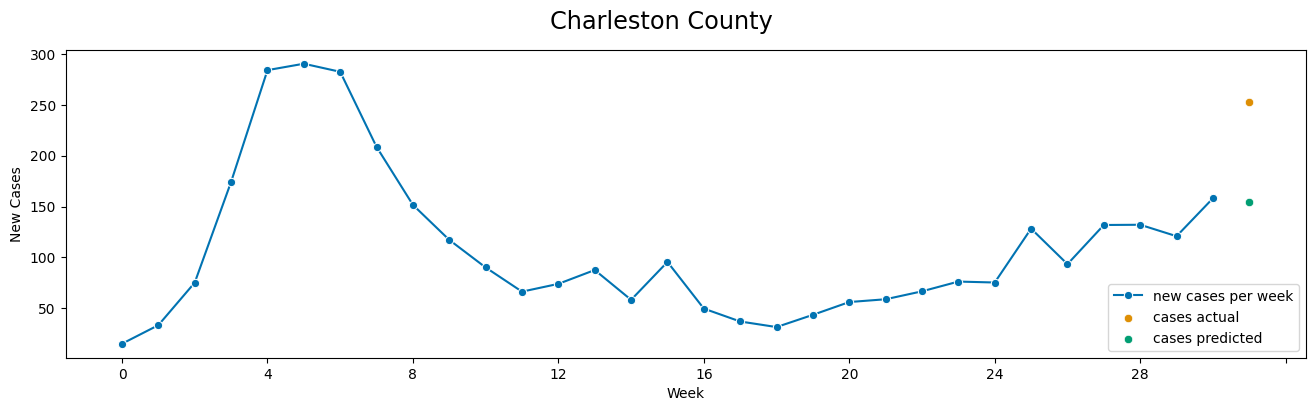

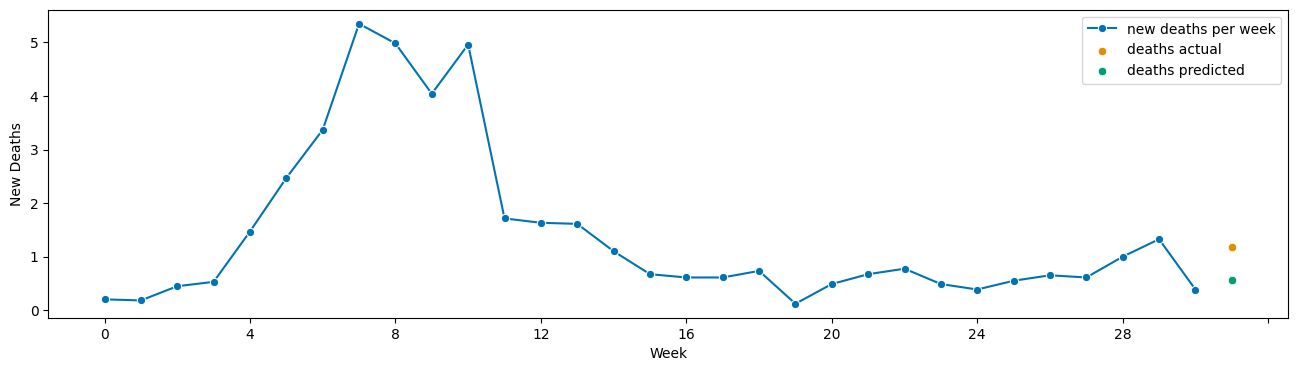

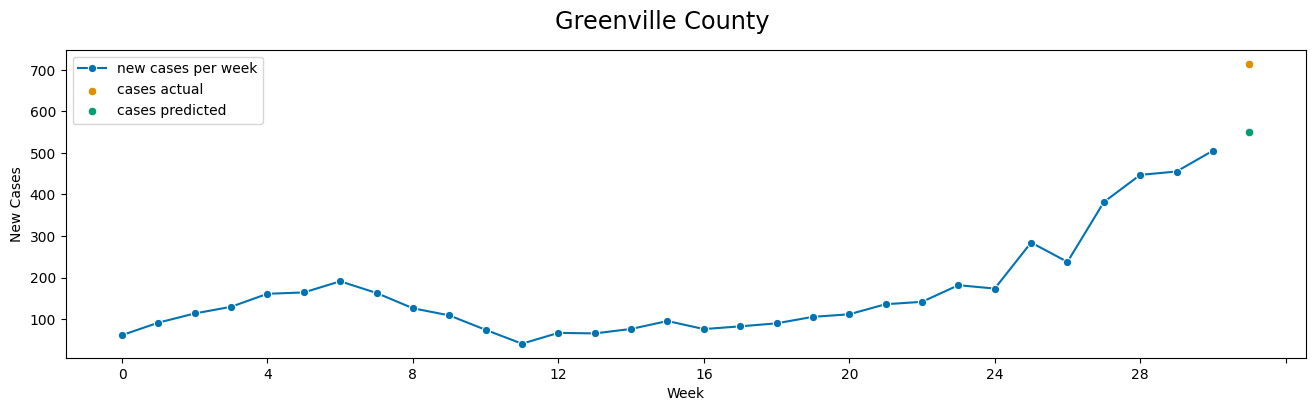

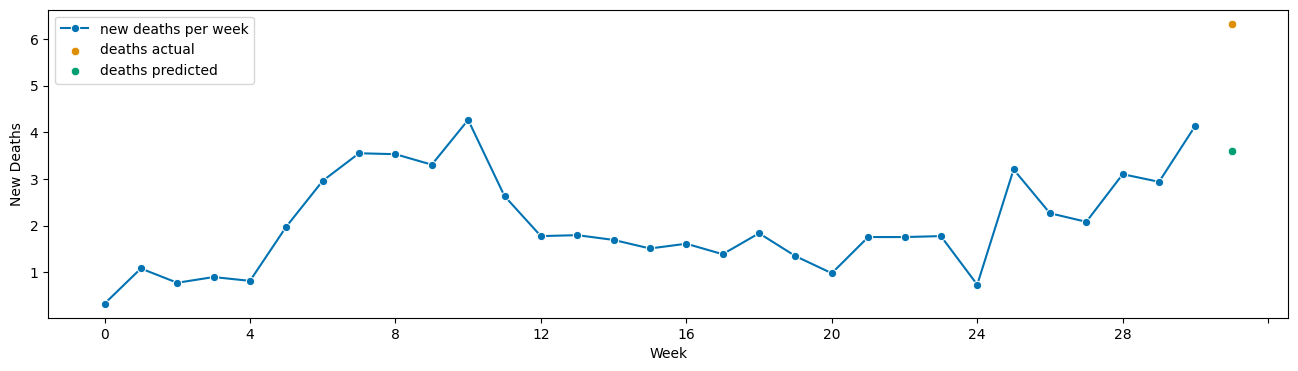

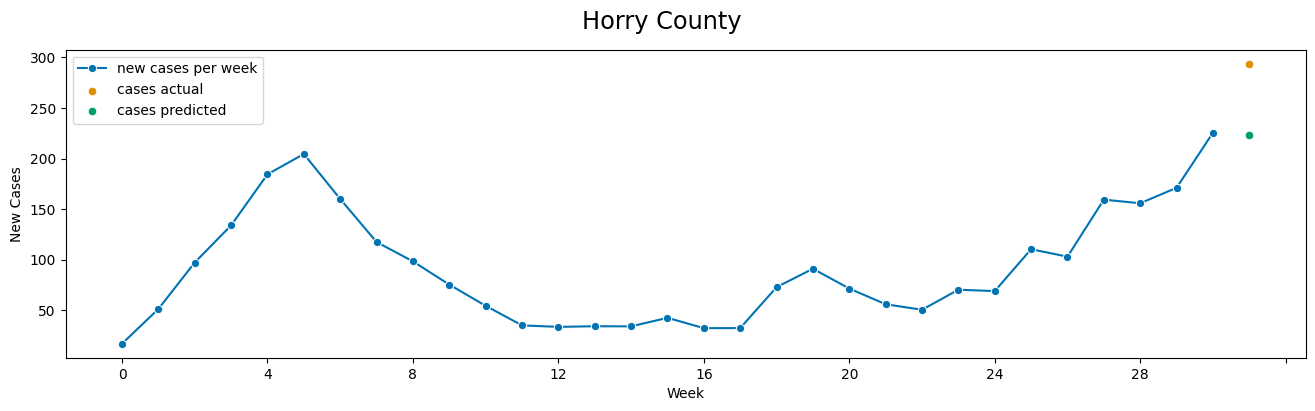

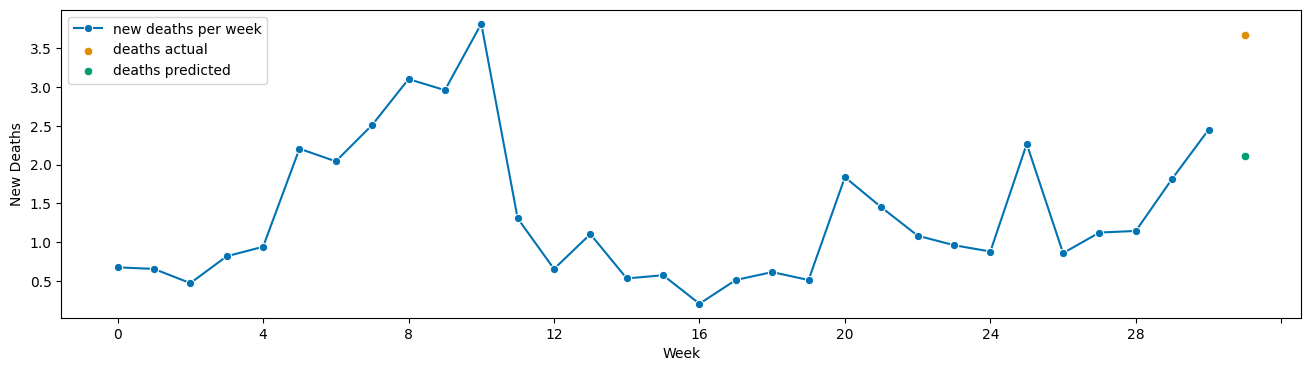

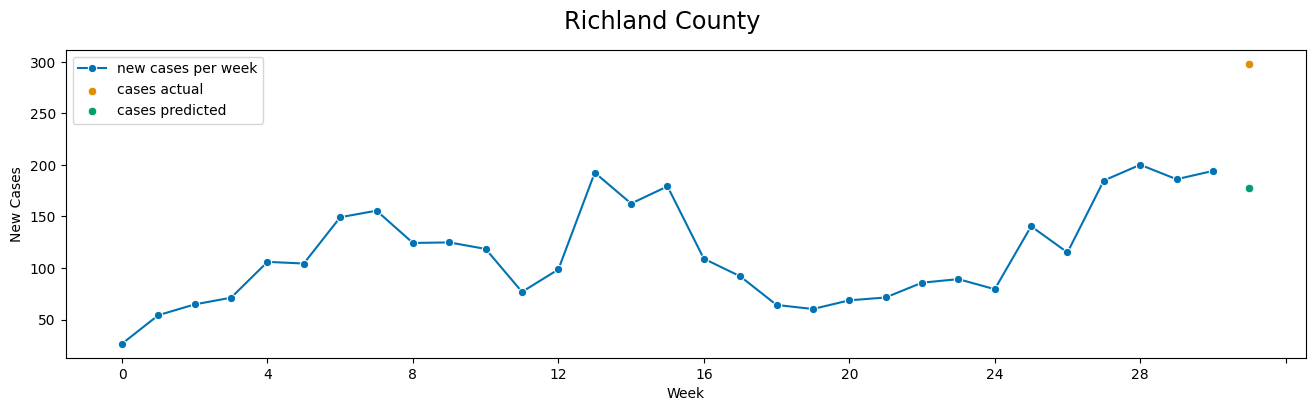

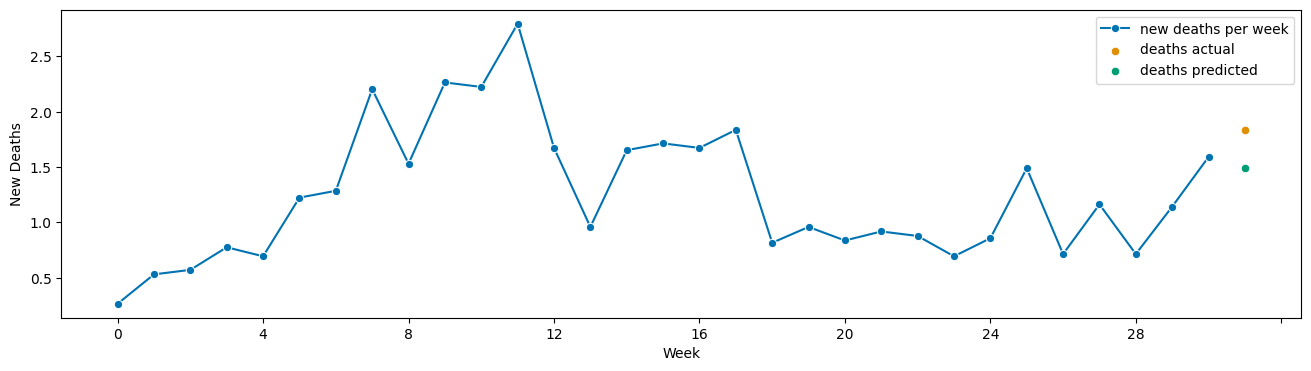

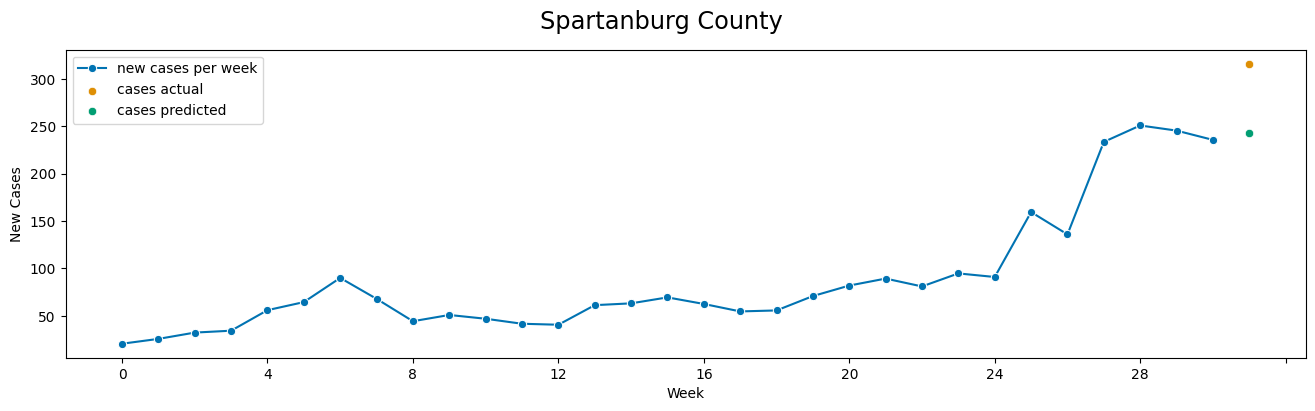

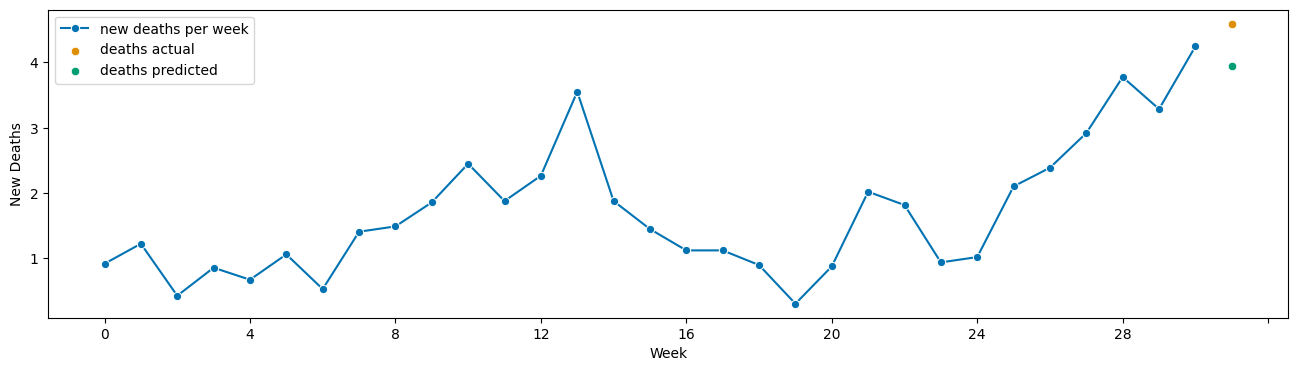

In [31]:
for i in range (5) :
    plot_series(cy_train[i], cy_test[i], cy_pred[i], labels=["new cases per week", "cases actual", "cases predicted"], 
            x_label='Week', y_label='New Cases', title=county_names[i])
    plot_series(dy_train[i], dy_test[i], dy_pred[i], labels=["new deaths per week", "deaths actual", "deaths predicted"], 
            x_label='Week', y_label='New Deaths')

In [43]:
for i in range (5) :
    MSE = mean_squared_error(cy_test[i],cy_pred[i])
    print(county_names[i], "   \tLinear reg RMSE:", np.sqrt(MSE), "(cases)")
    MSE = mean_squared_error(dy_test[i], dy_pred[i])
    print("\t\t\t\t\t", np.sqrt(MSE), "(deaths)")
    print("-------------------------------------------------------------------")

Charleston County     	Linear reg RMSE: 98.21492090355329 (cases)
					 0.6163518489556877 (deaths)
-------------------------------------------------------------------
Greenville County     	Linear reg RMSE: 163.13155563525766 (cases)
					 2.726845238559147 (deaths)
-------------------------------------------------------------------
Horry County     	Linear reg RMSE: 70.23875812223204 (cases)
					 1.5638128422100555 (deaths)
-------------------------------------------------------------------
Richland County     	Linear reg RMSE: 120.36742166778777 (cases)
					 0.34255214652909416 (deaths)
-------------------------------------------------------------------
Spartanburg County     	Linear reg RMSE: 73.12406196378893 (cases)
					 0.6517955726195761 (deaths)
-------------------------------------------------------------------


### Nonlinear Regression

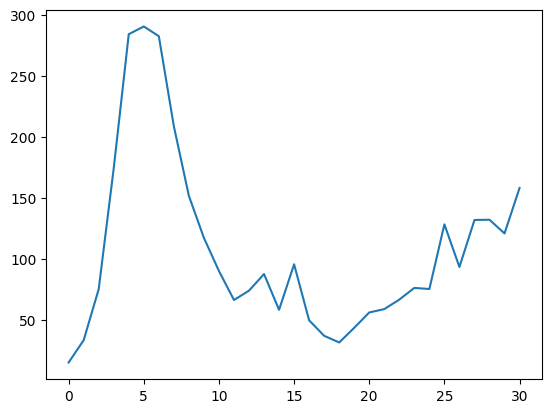